<a href="https://colab.research.google.com/github/dxbezerra/tvdi/blob/master/TVDI_projeto_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Projeto TVDI**

Autores: Diego, Raíssa, Stella, Gustavo

Disciplina de Introdução à Programação (SER-307)

Instituto Nacional de Pesquisas Espaciais (INPE)


---

Temperature-Vegetation Dryness Index (TVDI) proposto por Sandholt et al. (2002).

In [2]:
# Limpar dados, instalar bibliotecas e fazer download do shapefile
!rm -rf sample_data
!rm -rf processed
!pip install pymodis
!git clone https://github.com/dxbezerra/tvdi.git

# Importar módulos
import gdal
from gdalconst import *
import numpy as np
from glob import glob
import scipy
from os import path as osp
import os, calendar, itertools, sys, subprocess
from pymodis import downmodis
from pymodis.convertmodis_gdal import convertModisGDAL
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

     |████████████████████████████████| 2.6MB 2.7MB/s 
  Stored in directory: /root/.cache/pip/wheels/6a/8c/b2/ddf2b77df1137a05b5643e31e0ef745319fa86e299a27aaec8
Successfully built pymodis
Cloning into 'tvdi'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 28 (delta 10), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (28/28), done.
WxPython missing, no GUI enabled


In [3]:
# Criar diretório dos dados
path = './raw_data'
if not osp.exists(path):
    os.mkdir(path)
print(os.listdir('./'))

['.config', 'tvdi', 'raw_data']


# **Download das imagens**
A partir da biblioteca pyModis realizamos o download das imagens de interesse. No caso, utilizamos o produto MOD13A2 que corresponde ao índices de vegetação NDVI e EVI composto de 16 dias e o produto MOD11A2 correspondente a Temperature Superficial do Solo (TSS) para de um intervalo de 8 dias.
O período analisado é referente ao dia juliano 257 (segunda quinzena de Setembro), que é o período mais seco no Estado do Ceará.

In [4]:
# Usuário e senha Earthdata
user     = 'grupo_tvdi'
password = 'Ninguempodesaber1'

# Cenas e produtos a serem baixados
tiles    = 'h14v09','h13v09'
products = ['MOD13A2.006', 'MOD11A2.006']

# Período selecionado
day     = '2018-09-14'
enddate = '2018-09-29'

# Download
print('Realizando download...')

for p in products:
  modisDown = downmodis.downModis(destinationFolder=path,
  password=password, user=user, tiles=tiles, product=p, today=day,
  enddate=enddate)

  modisDown.connect()
  modisDown.downloadsAllDay()

print('Download completo.')

# Checkar imagens baixadas e o seu tamanho em megabytes
fls = sorted(glob(path + '/*.hdf'))
for f in fls:
  print(osp.basename(f),'-', osp.getsize(f)/10e5, 'MB')

Realizando download...
Download completo.
MOD11A2.A2018257.h13v09.006.2018266035239.hdf - 6.701147 MB
MOD11A2.A2018257.h14v09.006.2018266035104.hdf - 3.322762 MB
MOD11A2.A2018265.h13v09.006.2018282164825.hdf - 6.699373 MB
MOD11A2.A2018265.h14v09.006.2018282165559.hdf - 3.339318 MB
MOD13A2.A2018257.h13v09.006.2018282125001.hdf - 19.171178 MB
MOD13A2.A2018257.h14v09.006.2018282125732.hdf - 7.887101 MB


# **Extrair bandas de interesse das imagens**
Tendo em vista que as imagens MODIS são contidas de diversas bandas (ex.: banda de qualidade do pixel, presença de nuvens, ângulo solar zenital, etc.), as bandas de interesse  são primeiramente extraídas com o módulo *convertModisGDAL*. Para o produto MOD13A2 utilizamos o NDVI e para o produto MOD11A2 a banda utilizada é a do TSS capturado durante o dia (*LST_Day_1km*), ambos sendo a primeira banda.

In [5]:
# Selecionar as datas julianas únicas das imagens baixadas (np.unique seleciona apenas valores que não se repetem)
juliandays = np.unique([osp.basename(f).split(".")[1][-3:] for f in fls])

# Diretório de saída das bandas
path = './processed'
if not osp.exists(path):
  os.mkdir(path)

# Extrair bandas  
for f in fls:
  
  # Bandas selecionadas (Seleciona somente a primeira banda)
  subset = "1"
  
  # Extrair bandas com pymodis (obs: epsg é o código de reprojeção da imagem)
  fileout = osp.join(path, osp.basename(f)[:-4])
  extr = convertModisGDAL(f, fileout, subset, res=None, outformat='GTiff', epsg=4326)
  extr.run(quiet=True)
   
# Checkar bandas extraídas
fls = sorted(glob(path + '/*.tif'))
for f in fls:
  print(osp.basename(f))

MOD11A2.A2018257.h13v09.006.2018266035239_LST_Day_1km.tif
MOD11A2.A2018257.h14v09.006.2018266035104_LST_Day_1km.tif
MOD11A2.A2018265.h13v09.006.2018282164825_LST_Day_1km.tif
MOD11A2.A2018265.h14v09.006.2018282165559_LST_Day_1km.tif
MOD13A2.A2018257.h13v09.006.2018282125001_1 km 16 days NDVI.tif
MOD13A2.A2018257.h14v09.006.2018282125732_1 km 16 days NDVI.tif


#**Mosaicagem**
As imagens baixadas são correspondentes às cenas do MODIS (h14v09 e h13v09) e necessitam que sejam combinadas para o Estado do Ceará. Esse processo é realizado selecionando as imagens de mesmo produto e período, porém de cenas distintas. Mais adiante o GDAL é utilizado para criar o mosaico.

In [6]:
# Listas
products   = ['MOD13A2.006', 'MOD11A2.006']
juliandays = np.unique([osp.basename(f).split(".")[1][-3:] for f in fls])

# Selecionar imagens de mesmo produto e período, porém de cenas distintas
for p in products:
  p = p.split(".")[0]
  
  for jd in juliandays:

    # Selecionar todas as imagens criadas no passo anterior (bandas extraídas) para o mesmo produto
    glb = glob('./processed/{0}*.tif'.format(p))

    # Guardar imagens de cenas distintas de mesmo produto e de mesmo período em uma lista
    pair = []
    for im in glb:
      if jd in im:
        pair.append(im)
    
    # Se a lista de imagens não for vazia, prosseguir.
    if not pair == []:
    
      # Remover espaços no nome do arquivo (pra não dar problema com o GDAL)
      rm_spaces = pair[0].replace(" ", "")
      
      # Criar um novo nome para arquivo de saída
      fname = rm_spaces[:-4] + ".MOSAIC.vrt"

      # Criar mosaico com o GDAL utilizando o shell
      gdal.BuildVRT(fname, pair)
      translateCmd = 'gdal_translate -of GTiff {0} {1}.tif'.format(fname, fname[:-4])
      subprocess.call(translateCmd, shell=True)

# Checkar mosaicos criados
fls = sorted(glob(path + '/*MOSAIC.tif'))
for f in fls:
  print(osp.basename(f))

MOD11A2.A2018257.h13v09.006.2018266035239_LST_Day_1km.MOSAIC.tif
MOD11A2.A2018265.h14v09.006.2018282165559_LST_Day_1km.MOSAIC.tif
MOD13A2.A2018257.h14v09.006.2018282125732_1km16daysNDVI.MOSAIC.tif


# **Recorte para área de interesse**
Para focarmos somente na área de nosso interesse, realizamos um recorte utilizando o arquivo *shapefile* dos limites estaduais do Ceará, evitando assim o processamento de dados irrelevantes posteriormente.

In [7]:
# Arquivo shapefile
shp = './tvdi/ce.shp'
print(os.path.isfile(shp))

# Realizar corte a partir dos mosaico da pasta dos arquivos processados
for f in fls:
  
  # Nome do arquivo da imagem recortada
  fname = f[:-4] + ".CLIP.tif"

  # Realizar recorte com gdalwarp utilizando o shell
  warpCmd = 'gdalwarp -dstnodata -3000 -cutline {0} {1} {2}\
            -crop_to_cutline -overwrite'.format(shp, f, fname)
  subprocess.call(warpCmd, shell=True)

# Checkar recortes criados
fls = sorted(glob(path + '/*CLIP.tif'))
for f in fls:
  print(osp.basename(f))

True
MOD11A2.A2018257.h13v09.006.2018266035239_LST_Day_1km.MOSAIC.CLIP.tif
MOD11A2.A2018265.h14v09.006.2018282165559_LST_Day_1km.MOSAIC.CLIP.tif
MOD13A2.A2018257.h14v09.006.2018282125732_1km16daysNDVI.MOSAIC.CLIP.tif


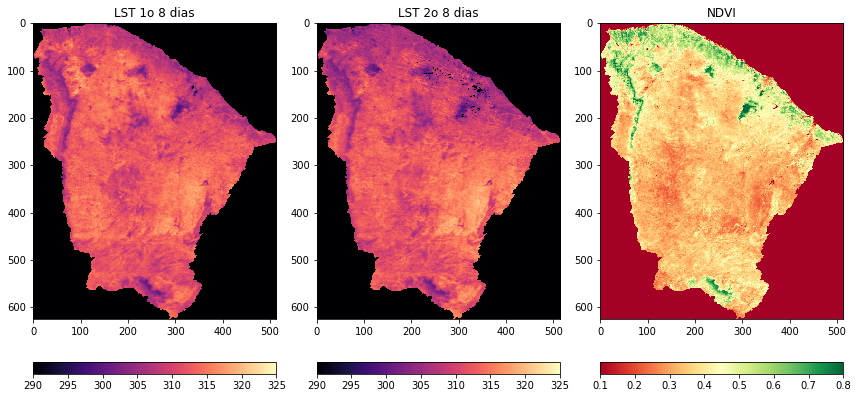

In [8]:
# Plot das imagens recortadas
dset_tss1, dset_tss2, dset_ndvi = gdal.Open(fls[0], GA_ReadOnly),\
                                  gdal.Open(fls[1], GA_ReadOnly),\
                                  gdal.Open(fls[2], GA_ReadOnly)

tss1_band, tss2_band, ndvi_band = dset_tss1.GetRasterBand(1),\
                                  dset_tss2.GetRasterBand(1),\
                                  dset_ndvi.GetRasterBand(1)

plt.figure(figsize=(12, 12))

plt.subplot(131)
plt.title("LST 1o 8 dias")
plt.imshow(tss1_band.ReadAsArray() * 0.02, cmap='magma', vmin=290, vmax=325)
plt.colorbar(orientation="horizontal", pad=0.05)

plt.subplot(132)
plt.title("LST 2o 8 dias")
plt.imshow(tss2_band.ReadAsArray() * 0.02, cmap='magma', vmin=290, vmax=325)
plt.colorbar(orientation="horizontal", pad=0.05)

plt.subplot(133)
plt.title("NDVI")
plt.imshow(ndvi_band.ReadAsArray() * 0.0001, cmap='RdYlGn', vmin=0.1, vmax=0.8)
plt.colorbar(orientation="horizontal", pad=0.05)

plt.tight_layout(pad=1)
plt.show()

dset_tss1, dset_tss2, dset_ndvi = None, None, None

# **Acessar imagens**
Para igualar o período observado entre as imagens de NDVI e TSS, nesta seção é realizada uma média temporal das duas imagens TSS de 8 dias. 

In [0]:
fls = sorted(glob(path + '/*CLIP.tif'))

# Carregar imagens de temperatura
dset_tss1 = gdal.Open(fls[0], GA_ReadOnly)
dset_tss2 = gdal.Open(fls[1], GA_ReadOnly)

dset_tss1_band = dset_tss1.GetRasterBand(1)
dset_tss2_band = dset_tss2.GetRasterBand(1)

# Multiplicar pelo fator de escala
dset_tss1_array = dset_tss1_band.ReadAsArray() * 0.02
dset_tss2_array = dset_tss2_band.ReadAsArray() * 0.02

# Criar máscara (substituir np.nan para valores de 0, que são os valores inválidos)
dset_tss1_array[dset_tss1_array == 0] = np.nan
dset_tss2_array[dset_tss2_array == 0] = np.nan

# Calcular média temporal ignorando nan
stack_2d = np.array([dset_tss1_array, dset_tss2_array])
TSS      = scipy.nanmean(stack_2d, axis=0) # média: 311.56830648359954

# Fechar datasets
dset_tss1, dset_tss2 = None, None

# Arredondar para duas casas decimais e printar valor médio de TSS
TSS = np.round(TSS, 2)

O acesso à imagem de NDVI segue da seguinte forma:

In [0]:
# Carregar imagem de NDVI
dset_ndvi = gdal.Open(fls[2], GA_ReadOnly)
ndvi_band = dset_ndvi.GetRasterBand(1)
gt        = dset_ndvi.GetGeoTransform()

# Multiplicar pelo fator de escala
NDVI      = ndvi_band.ReadAsArray() * 0.0001

# Criar máscara (substituir np.nan para valores de 0, que são os valores inválidos)
NDVI[NDVI == -0.3] = np.nan

# Fechar dataset
dset_ndvi = None

# Arredondar para duas casas decimais e printar valor médio de NDVI
NDVI = np.round(NDVI, 2)

Visualização das imagens escaladas e histogramas:

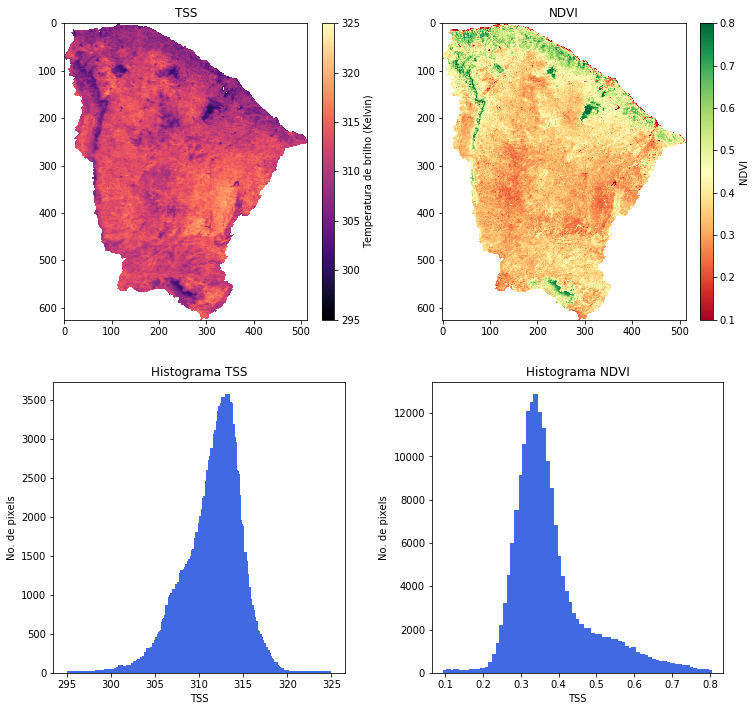

In [11]:
# Tamanho do plot
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12,12))
plt.subplots_adjust(left=0.125, right = 0.9, wspace=0.3)

# Subplot TSS
img1 = ax1.imshow(TSS, cmap='magma', vmin=295, vmax=325)
ax1.set_title("TSS")
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes("right", size="5%", pad=0.2)
cbar = fig.colorbar(img1, cax=cax1)
cbar.set_label("Temperatura de brilho (Kelvin)")

# Subplot NDVI
img2 = ax2.imshow(NDVI, cmap='RdYlGn', vmin=0.1, vmax=0.8)
ax2.set_title("NDVI")
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes("right", size="5%", pad=0.2)
cbar = fig.colorbar(img2, cax=cax2)
cbar.set_label("NDVI")

# Subplot Histograma TSS
img3 = ax3.hist(TSS.ravel(), bins=256, range=(295, 325), lw=4, ec='royalblue')
ax3.set_aspect(1./ax3.get_data_ratio())
ax3.set_title("Histograma TSS")
ax3.set_xlabel('TSS')
ax3.set_ylabel('No. de pixels')

# Subplot Histograma NDVI
img4 = ax4.hist(NDVI.ravel(), bins=256, range=(0.1, 0.8), lw=4, ec='royalblue')
ax4.set_aspect(1./ax4.get_data_ratio())
ax4.set_title("Histograma NDVI")
ax4.set_xlabel('TSS')
ax4.set_ylabel('No. de pixels')

# Remover bordas da figura
fig.show()

# **Tratamento dos dados**

Criar matrizes de Latitude e Longitude

In [12]:
print("Geotransform:", gt)

# lat lon arrays
x = np.linspace(gt[0], gt[0] + gt[1] * NDVI.shape[1], NDVI.shape[1])
y = np.linspace(gt[3], gt[3] + gt[5] * NDVI.shape[0], NDVI.shape[0])

xx, yy = np.meshgrid(x, y)
print(xx.shape, yy.shape)

Geotransform: (-41.423518008999984, 0.00811328187548637, 0.0, -2.784230650091664, 0.0, -0.008105354346907763)
(626, 514) (626, 514)


Eliminar outliers

In [13]:
# Retirar valores fora de 3 desvios padrões da imagem de TSS

# TSS
std  = np.nanstd(TSS)
mean = np.nanmean(TSS)
print(std, mean)
lower_limit = mean - (std*3)
upper_limit = mean + (std*3)

print(lower_limit, upper_limit)

np.where(TSS, TSS < lower_limit, np.nan)
np.where(TSS, TSS > upper_limit, np.nan)

print(np.nanmin(TSS), np.nanmax(TSS))

# Retirar valores menores que zero na imagem de NDVI
NDVI[NDVI < 0] = np.nan

3.049304133522359 311.568434601655
302.4205222010879 320.71634700222205
298.25 320.41


# **Cálculo das retas**

Criar matriz 4D

In [0]:
# val = 0.5
# loc = np.where(NDVI == val)
# print(loc)
# row, col = loc
# #print(len(row))
# #print(len(col))


# for i in range(len(col)):
#   print(row[i], col[i])
#   #print()

Retirar valores máximos e mínimos

In [0]:
MiniList    = []
MaxList     = []
NDVI_vector = np.arange(0.01, 1.01, 0.01)

for val in NDVI_vector:
  TSS_vector_val = []
  row, col = np.where(NDVI == val)
  #print(row, col)
  for i in range(len(row)):
    if np.isfinite(TSS[row[i], col[i]]):
      #print(TSS[row[i], col[i]])
      TSS_vector_val += [TSS[row[i], col[i]]]
  
  if TSS_vector_val != []:
    TSS_min_val = np.min(TSS_vector_val)
    TSS_max_val = np.max(TSS_vector_val)
  else:
    TSS_min_val = np.nan
    TSS_max_val = np.nan

  #print(TSS_min_val)
  MiniList += [TSS_min_val]
  MaxList  += [TSS_max_val]

[299.44, 304.72, 304.92, 304.71, 301.12, nan, nan, 302.83, 299.72, nan, 303.9, 301.11, 301.23, 300.72, nan, 300.31, 301.45, nan, 301.96, 300.92, nan, 301.02, 302.3, nan, 302.53, 301.02, 302.35, 301.17, nan, 301.63, 298.77, 302.84, 301.0, 302.51, nan, nan, 302.13, 299.98, 300.4, 301.1, nan, nan, 301.14, 301.68, 302.22, 301.17, nan, nan, 301.55, 301.05, 299.92, 301.21, 301.26, 301.37, 299.98, 301.08, nan, nan, 300.13, 299.22, 301.8, 300.4, 300.35, 300.08, 301.11, 300.32, 299.72, 300.03, nan, nan, nan, 299.01, 298.93, 299.56, 299.66, 299.96, 299.43, 299.82, 299.02, 299.8, 298.34, nan, nan, nan, 298.45, 298.59, 298.25, 299.0, nan, nan, 302.05, nan, nan, nan, nan, nan, nan, nan, nan, nan]
[306.25, 305.82, 309.67, 307.07, 310.56, nan, nan, 311.21, 311.49, nan, 313.03, 311.18, 312.75, 309.64, nan, 314.41, 317.82, nan, 318.03, 318.65, nan, 319.64, 320.19, nan, 320.11, 319.62, 319.78, 319.82, nan, 319.65, 319.71, 318.77, 319.24, 318.78, nan, nan, 318.51, 318.11, 318.81, 319.55, nan, nan, 316.46

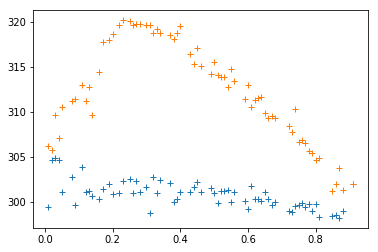

In [16]:
print(MiniList)
print(MaxList)
#print(NDVI_vector)

print(" ")
print(len(MiniList))
print(len(MaxList))
print(len(NDVI_vector))

plt.plot(NDVI_vector, MiniList, '+')
plt.plot(NDVI_vector, MaxList, '+')

![TVDI](https://docs.google.com/uc?export=download&id=1A6Q1dTh-qZkug1T5DQqfCyadMC8R_WDM)

Retirar coeficientes *a* e *b* para cálculo do TVDI

In [17]:
#LimiteMax = np.polyfit(NDVI_vector, MaxList, 1)
#LimiteMin = np.polyfit(NDVI_vector, MiniList, 1)
#print(LimiteMax)


# Reta minimo
MiniList_fin = []
NDVI_fin = []

for i, val in enumerate(MiniList):
  if np.isfinite(val):
    MiniList_fin += [val]
    NDVI_fin += [NDVI_vector[i]]
print(MiniList_fin)
print(NDVI_fin)

MinPfit = np.polyfit(NDVI_fin[17:], MiniList_fin[17:], 1)
print(MinPfit)

# Reta maximo
MaxList_fin = []
NDVI_fin = []
for i, val in enumerate(MaxList):
  if np.isfinite(val):
    MaxList_fin += [val]
    NDVI_fin += [NDVI_vector[i]]
print(MaxList_fin)
print(NDVI_fin)


MaxPfit = np.polyfit(NDVI_fin[17:], MaxList_fin[17:], 1)
print(MaxPfit)

[299.44, 304.72, 304.92, 304.71, 301.12, 302.83, 299.72, 303.9, 301.11, 301.23, 300.72, 300.31, 301.45, 301.96, 300.92, 301.02, 302.3, 302.53, 301.02, 302.35, 301.17, 301.63, 298.77, 302.84, 301.0, 302.51, 302.13, 299.98, 300.4, 301.1, 301.14, 301.68, 302.22, 301.17, 301.55, 301.05, 299.92, 301.21, 301.26, 301.37, 299.98, 301.08, 300.13, 299.22, 301.8, 300.4, 300.35, 300.08, 301.11, 300.32, 299.72, 300.03, 299.01, 298.93, 299.56, 299.66, 299.96, 299.43, 299.82, 299.02, 299.8, 298.34, 298.45, 298.59, 298.25, 299.0, 302.05]
[0.01, 0.02, 0.03, 0.04, 0.05, 0.08, 0.09, 0.11, 0.12, 0.13, 0.14, 0.16, 0.17, 0.19, 0.2, 0.22, 0.23, 0.25, 0.26, 0.27, 0.28, 0.3, 0.31, 0.32, 0.33, 0.34, 0.37, 0.38, 0.39, 0.4, 0.43, 0.44, 0.45, 0.46, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.85, 0.86, 0.87, 0.88, 0.91]
[ -4.26313638 302.91605087]
[306.25, 305.82, 309.67, 307.07, 310.56, 311.21

# **Cálculo do TVDI**

![TVDI](https://docs.google.com/uc?export=download&id=1nh-vaYSW5A-g5N2uour3zTiABSmvv86z)

Cálculo

In [18]:
#TVDI = np.full(shape[0], shape[1], np.nan)

a1, b1 = MaxPfit
a2, b2 = MinPfit
print(a1,b1)
print(a2,b2)

Ts_max = b1 + (a1 * NDVI)
Ts_min = b2 + (a2 * NDVI)

TVDI = (TSS - Ts_min) / (Ts_max - Ts_min)

# for ii in range(NDVI.shape[0]):
#   for jj in range(NDVI.shape[1]):
#     TVDI[ii, jj] = (TSS)

print(np.nanmin(TVDI))
print(np.nanmax(TVDI))

-29.396226623574147 329.0440454020608
-4.263136377448284 302.91605087152294
-0.2245602909522193
1.4023054893629432


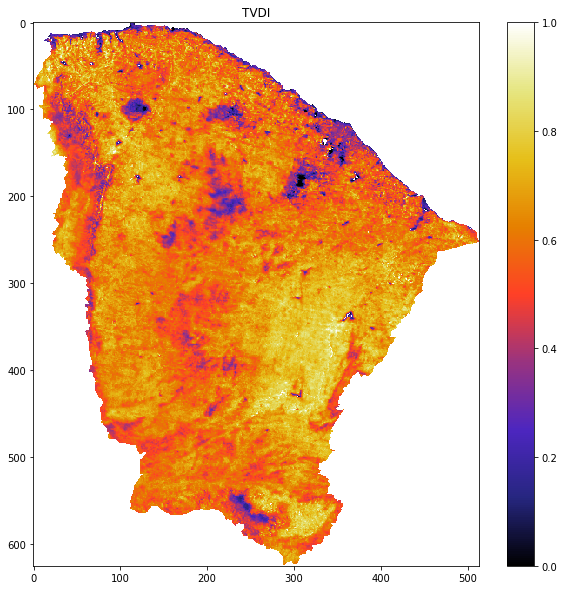

In [47]:
# proximo a 1 é seco e proximo a 0 é umido
plt.figure(figsize=(10, 10))

plt.imshow(TVDI, cmap='CMRmap', vmin=0, vmax=1)
plt.title("TVDI")

plt.colorbar(orientation="vertical", pad=0.05)


Text(0, 0.5, 'No. de pixels')

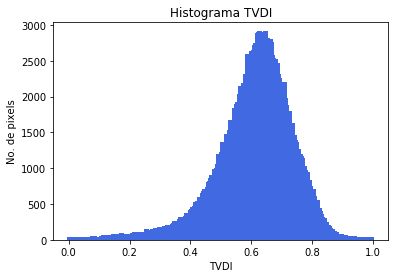

In [71]:
plt.hist(TVDI.ravel(), bins=256, range=(0, 1), lw=4, ec='royalblue')
plt.title("Histograma TVDI")
plt.xlabel('TVDI')
plt.ylabel('No. de pixels')

Criar matriz 5D e salvar dados (NetCDF?) 

Salvar imagem TVDI em formato GeoTIFF

# Referências

SANDHOLT, I.; RASMUSSEN, K.; ANDERSEN, J. A simple interpretation of the surface temperature/vegetation index space for assessment of surface moisture status. **Remote Sensing of environment**, v. 79, n. 2-3, p. 213-224, 2002.